# Task detector v2

### The first version of this task had many issues:
- The model used for the task recognition was not well suited for this. We will now directly use the LSTM decoder to see what is the R2 when trying to predict velocity.
- We need to further explore how each perturbation affects performance of the model to understand the optimal range of perturbations.

### Imports

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
import sys
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import math

# Imports DL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import copy


# Imports from other modules and packages in the project
sys.path.append('../')

from src.helpers import *
from src.visualize import *
from src.trainer import *
from src.trainer_hnet import * 
from Models.models import *

c:\Users\nerea\anaconda3\envs\sinthlab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

In [3]:
from pyaldata import *

In [4]:
name = 'Chewie'
date = '1007'
fold = 0
target_variable = 'vel'

In [5]:
dtype = torch.float32

In [6]:
## Load pre-processed data
data_path = '../Data/Processed_Data/Tidy_'+name+'_'+date+'.pkl'

with open(data_path, 'rb') as file:
    tidy_df = pickle.load(file)
baseline_df = tidy_df.loc[tidy_df['epoch'] == 'BL']

## 1) Train RNN decoder on Baseline data to predict velocity

#### Get train-val-test split

In [7]:
xx_train_base, yy_train_base, xx_val_base, yy_val_base,\
      xx_test_base, yy_test_base, info_train_base, info_val_base,\
          info_test_base, list_mins_base, \
            list_maxs_base= get_dataset(baseline_df, 
                                        fold, target_variable= target_variable, 
                                        no_outliers = False, force_data = True,
                                        std = False)

Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0


In [8]:
# Specify that we want our tensors on the GPU and in float32
#device = torch.device('cuda:0') #suposed to be cuda
device = torch.device('cpu') 
dtype = torch.float32
path_to_models = './Models/Models_Force'

# Set the seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)  # If using CUDA

num_dim_output = yy_train_base.shape[2]
num_features = xx_train_base.shape[2]

In [9]:
# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1e-5
l1_ratio_reg = 0.5

lr = 0.00001
loss_function = huber_loss
delta = 8  # hyperparameter for huber loss

# Hyperparameters RNN class
hidden_units = 300
num_layers = 1
input_size = 49
dropout = 0.2

#Other training hyperparameters

lr_gamma= 1.37 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 19
batch_size_train= 25
batch_size_val = 25

torch.manual_seed(42)

####### Define model
model_base =  Causal_Simple_RNN(num_features=num_features, 
                hidden_units= hidden_units, 
                num_layers = num_layers, 
                out_dims = num_dim_output,
                dropout = dropout).to(device)

#### Train model

In [10]:
train_losses, val_losses = \
    train_model(model_base, 
                xx_train_base,yy_train_base,
                xx_val_base, 
                yy_val_base,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer= Regularizer_RNN, 
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5)

Epoch 000 Train 12.3206 Val 12.1829
Epoch 001 Train 11.0901 Val 11.1057
Epoch 002 Train 9.9904 Val 10.0296
Epoch 003 Train 8.9918 Val 9.0480
Epoch 004 Train 8.1037 Val 8.1981
Epoch 005 Train 7.2726 Val 7.4013
Epoch 006 Train 6.5055 Val 6.6441
Epoch 007 Train 5.7831 Val 5.9567
Epoch 008 Train 5.1243 Val 5.3311
Epoch 009 Train 4.5339 Val 4.7983
Epoch 010 Train 3.9906 Val 4.2951
Epoch 011 Train 3.4802 Val 3.8758
Epoch 012 Train 3.0629 Val 3.5442
Epoch 013 Train 2.7070 Val 3.2432
Epoch 014 Train 2.4208 Val 3.0292
Epoch 015 Train 2.1865 Val 2.8397
Epoch 016 Train 2.0007 Val 2.6846
Epoch 017 Train 1.8513 Val 2.5375
Epoch 018 Train 1.7278 Val 2.4443
Epoch 019 Train 1.6259 Val 2.3231
Epoch 020 Train 1.5357 Val 2.2416
Epoch 021 Train 1.4601 Val 2.1801
Epoch 022 Train 1.3891 Val 2.1023
Epoch 023 Train 1.3396 Val 2.0617
Epoch 024 Train 1.3018 Val 2.0676
Epoch 025 Train 1.2766 Val 2.0121
Epoch 026 Train 1.2528 Val 1.9705
Epoch 027 Train 1.2273 Val 1.9812
Epoch 028 Train 1.2152 Val 1.9448
Epoch 029

#### Evaluate model on baseline

In [11]:
y_hat, y_true,\
      train_score, v_score,\
          test_score = eval_model(xx_train_base,
                                   yy_train_base, 
                                   xx_val_base, 
                                   yy_val_base,
                                   xx_test_base, 
                                   yy_test_base, 
                                   model_base, 
                                   metric = 'r2')

Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 


## 2) Test different ratios and std for the simulated data

In [12]:
def remove_neurons(matrix, ratio):
    sim_data = matrix.copy()
    num_total_neurons = matrix.shape[1]
    num_removed = int((ratio/100)*num_total_neurons)
    idx_removed = random.sample(list(np.arange(0,num_total_neurons)), num_removed)
    for i in idx_removed:
        sim_data[:,i] = 0
    return sim_data

In [13]:
def shuffle_neurons(matrix, ratio):
    sim_data = matrix.copy()
    num_total_neurons = matrix.shape[1]
    num_neurons_to_shuffle = int((ratio/100)*num_total_neurons)
    ind_to_permute = random.sample(list(np.arange(0,num_total_neurons)), num_neurons_to_shuffle)
    ind_to_permute = np.sort(ind_to_permute)
    permuted_indices = np.random.permutation(ind_to_permute)
    for i, new_i in zip(ind_to_permute, permuted_indices):
        sim_data[:,i] = matrix[:,new_i]
    return sim_data

In [14]:
def modify_neurons(matrix, std_gain, std_offset):
    sim_data1 = matrix.copy()
    sim_data2 = matrix.copy()
    
    ### a) Multiplying each column by a random gain from gaussian dist.
    gains = np.random.normal(1, std_gain, size=sim_data1.shape[1])
    # Multiply each column of the matrix by the corresponding gain value
    sim_data1 = sim_data1 * gains[:, np.newaxis].T
    
    ### b) Random offsets
    offsets = np.random.normal(0, std_offset, size=sim_data2.shape[1])
    # Multiply each column of the matrix by the corresponding gain value
    sim_data2 = sim_data2 + offsets[:, np.newaxis].T

    return sim_data1, sim_data2

In [15]:
data_matrix = np.vstack(baseline_df['both_rates'])

In [16]:
ratios = np.arange(0,110,10)
v_scores_removed = []
v_scores_shuffled = []

for r in ratios:
  for i in range(10):
      v_scores_removed_i = []
      v_scores_shuffled_i = []
      # First removed neurons
      sim_data = remove_neurons(data_matrix, r)
      baseline_df_sim = baseline_df.copy()
      baseline_df_sim['both_rates'] = sim_data.tolist()
      xx_train_sim, yy_train_sim, xx_val_sim, yy_val_sim,\
        xx_test_sim, yy_test_sim, info_train_sim, info_val_sim,\
            info_test_sim, list_mins_sim, \
              list_maxs_base= get_dataset(baseline_df_sim, 
                                          fold, 
                                          target_variable= target_variable,
                                          no_outliers = False, 
                                          force_data = True, 
                                          std = False)
      y_hat, y_true, train_score,\
        v_score, test_score = eval_model(xx_train_sim, 
                                          yy_train_sim, 
                                          xx_val_sim, 
                                          yy_val_sim,\
                                          xx_test_sim, 
                                          yy_test_sim,
                                          model_base, 
                                          metric = 'r2')
      v_scores_removed_i.append(v_score)

      # Second shuffled neurons
      sim_data = shuffle_neurons(data_matrix, r)
      baseline_df_sim = baseline_df.copy()
      baseline_df_sim['both_rates'] = sim_data.tolist()
      xx_train_sim, yy_train_sim, xx_val_sim, yy_val_sim,\
        xx_test_sim, yy_test_sim, info_train_sim, info_val_sim,\
            info_test_sim, list_mins_sim, \
              list_maxs_base= get_dataset(baseline_df_sim, 
                                          fold, 
                                          target_variable= target_variable,
                                          no_outliers = False, 
                                          force_data = True, 
                                          std = False)
      y_hat, y_true, train_score,\
        v_score, test_score = eval_model(xx_train_sim, 
                                          yy_train_sim, 
                                          xx_val_sim, 
                                          yy_val_sim,\
                                          xx_test_sim, 
                                          yy_test_sim,
                                          model_base, 
                                          metric = 'r2')
      v_scores_shuffled_i.append(v_score)
  v_scores_removed.append(np.median(v_scores_removed_i))
  v_scores_shuffled.append(np.median(v_scores_shuffled_i))
    
    

Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train 

In [17]:
stds_gain = np.arange(0,1.4,0.1)
stds_offset = np.arange(0,41,3)

v_scores_gain = []
v_scores_offset = []
for s_g, s_o in zip(stds_gain,stds_offset) :

    for i in range(10):
        v_scores_gain_i = []
        v_scores_offset_i = []
        # First removed neurons
        sim_data1, sim_data2 = modify_neurons(data_matrix, s_g, s_o)
        baseline_df_sim = baseline_df.copy()
        baseline_df_sim['both_rates'] = sim_data1.tolist()
        xx_train_sim, yy_train_sim, xx_val_sim, yy_val_sim,\
          xx_test_sim, yy_test_sim, info_train_sim, info_val_sim,\
              info_test_sim, list_mins_sim, \
                list_maxs_base= get_dataset(baseline_df_sim, 
                                            fold, 
                                            target_variable= target_variable,
                                            no_outliers = False, 
                                            force_data = True, 
                                            std = False)
        y_hat, y_true, train_score,\
          v_score, test_score = eval_model(xx_train_sim, 
                                            yy_train_sim, 
                                            xx_val_sim, 
                                            yy_val_sim,\
                                            xx_test_sim, 
                                            yy_test_sim,
                                            model_base, 
                                            metric = 'r2')
        v_scores_gain_i.append(v_score)

        # Second shuffled neurons
        baseline_df_sim = baseline_df.copy()
        baseline_df_sim['both_rates'] = sim_data2.tolist()
        xx_train_sim, yy_train_sim, xx_val_sim, yy_val_sim,\
          xx_test_sim, yy_test_sim, info_train_sim, info_val_sim,\
              info_test_sim, list_mins_sim, \
                list_maxs_base= get_dataset(baseline_df_sim, 
                                            fold, 
                                            target_variable= target_variable,
                                            no_outliers = False, 
                                            force_data = True, 
                                            std = False)
        y_hat, y_true, train_score,\
          v_score, test_score = eval_model(xx_train_sim, 
                                            yy_train_sim, 
                                            xx_val_sim, 
                                            yy_val_sim,\
                                            xx_test_sim, 
                                            yy_test_sim,
                                            model_base, 
                                            metric = 'r2')
        v_scores_offset_i.append(v_score)

    v_scores_gain.append(np.median(v_scores_gain_i))
    v_scores_offset.append(np.median(v_scores_offset_i))

Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train 

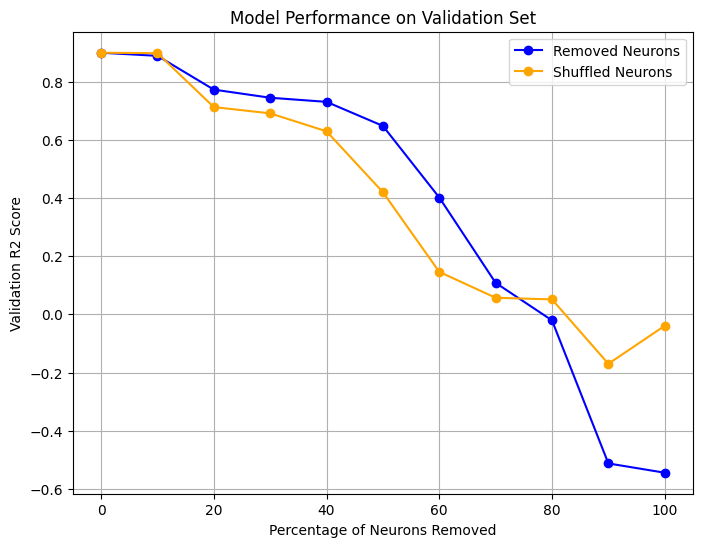

In [18]:
# Plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.plot(ratios, v_scores_removed, marker='o', color='b', linestyle='-', label = 'Removed Neurons')
plt.plot(ratios, v_scores_shuffled, marker='o', color='orange', linestyle='-', label = 'Shuffled Neurons')

# Add labels and title
plt.xlabel('Percentage of Neurons Removed')
plt.ylabel('Validation R2 Score')
plt.title('Model Performance on Validation Set')
plt.legend()
# Add grid lines
plt.grid(True)

# Customize ticks and tick labels if needed
# plt.xticks(ratios)
# plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9])

# Show plot
plt.show()

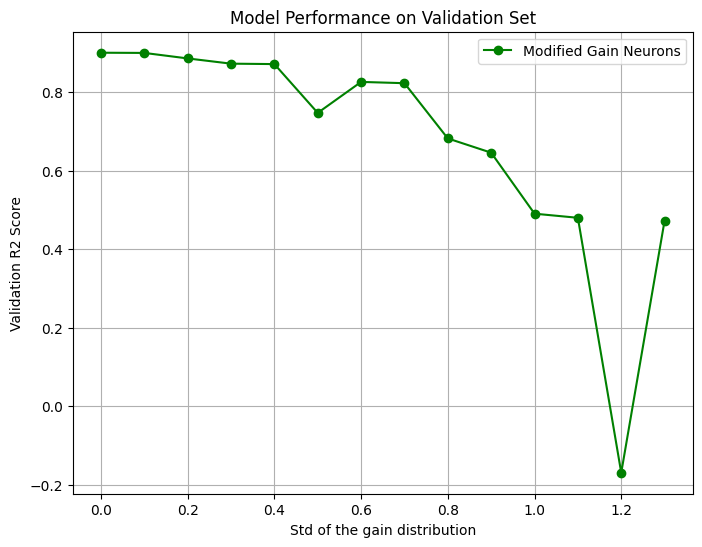

In [19]:
# Plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.plot(stds_gain, v_scores_gain, marker='o', color='g', linestyle='-', label = 'Modified Gain Neurons')

# Add labels and title
plt.xlabel('Std of the gain distribution')
plt.ylabel('Validation R2 Score')
plt.title('Model Performance on Validation Set')
plt.legend()
# Add grid lines
plt.grid(True)

# Customize ticks and tick labels if needed
# plt.xticks(ratios)
# plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9])

# Show plot
plt.show()

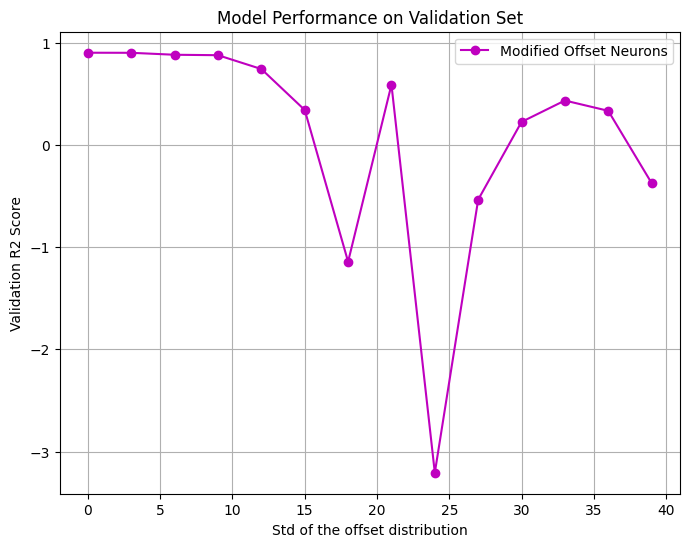

In [20]:
# Plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.plot(stds_offset, v_scores_offset, marker='o', color='m', linestyle='-', label = 'Modified Offset Neurons')

# Add labels and title
plt.xlabel('Std of the offset distribution')
plt.ylabel('Validation R2 Score')
plt.title('Model Performance on Validation Set')
plt.legend()
# Add grid lines
plt.grid(True)

# Customize ticks and tick labels if needed
# plt.xticks(ratios)
# plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9])

# Show plot
plt.show()


__Conclusion__:
- Single perturbations (removing neurons, shuffling neurons, adding gain or offset) for a performance of less than 60% R2 need to be:
    - 30% shufled neurons
    - 60% "removed" neurons
    - 0.7std for gain distribution with mean 1
    - 16-18 std for aoofset distribution with mean 0

We can now either consider each perturbation a single task or mix them and create different datasets.

## 3) Test algorithm with 1 of the previous perturbations
`Reminder algorithm:`

#### The following part of the code should correspond to this logic/algorithm structure:

**Initialize with first task (~pretraining):**
- 1- Load Baseline Data and set task_id to 0, and max_id to 0 too
- 2- Train TaskDetectorRNN on Baseline Data
- 3- Compute R2 and define threshold
- 4- Create folder to save trained task detector models and save it with the name of the task (here 0)
- 5- Train hnet using task_id = 0.

**Continue with new data (could be the same task):**
- 6- Load new data
- 7- For each of the previous tasks test the trained TaskDetectorRNN and compute the R2 score. Save in a list all R2 scores.
    - if max(r2_list) > thrs: get argmax of the list as the task_id
        - use h_net with the task_id corresponding to the data.
        - report results (R2,...)
    - else:
        - max_id += 1
        - task_id = max_id
        - train TaskDetectorRNN on new data and save it with its task_id
        - check R2 > threshold --> else report ERROR.
        - train h_net using this task_id.
        - report results (R2,...)

In [21]:
def save_model(model, task_id, folder):
    # Define the directory path
    models_dir = "../Models"
    task_models_dir = os.path.join(models_dir, folder)

    # Check if the directory exists, if not, create it
    if not os.path.exists(task_models_dir):
        os.makedirs(task_models_dir)

    # Define the file name
    model_file_name = f"Model_Task_{task_id}.pth"  # Use .pth extension for PyTorch models

    # Save the model
    model_path = os.path.join(task_models_dir, model_file_name)

    # Save the model using torch.save
    torch.save(model, model_path)


In [22]:
task_id = 0
max_id = 0

In [23]:
task_detector = copy.deepcopy(model_base)
# Save the trained model
save_model(task_detector, task_id, "Models_Task_Recognition")

In [24]:
y_hat, y_true,\
      train_score, v_score,\
          test_score = eval_model(xx_train_base,
                                   yy_train_base, 
                                   xx_val_base, 
                                   yy_val_base,
                                   xx_test_base, 
                                   yy_test_base, 
                                   task_detector, 
                                   metric = 'r2')
r2_max = v_score
thrs = 0.90*r2_max
print('The threshold to belong to task 0 is an R2 of : ', thrs)

Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
The threshold to belong to task 0 is an R2 of :  0.8100749201633122


### 3.1- Train hypernetwork on task 0

In [25]:

num_dim_output = yy_train_base.shape[2]
num_features = xx_train_base.shape[2]

# Hyperparameters LSTM class (from force model without hnet)
# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1e-5
l1_ratio_reg = 0.5

loss_function = huber_loss
delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
n_hidden_units = 300
num_layers = 1
input_size = 49
dropout = 0.2

#Other training hyperparameters

lr_gamma= 1.37 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 19
batch_size_train= 25
batch_size_val = 25

lr = 0.001
beta = 1e-1


torch.manual_seed(42)

In [26]:
from hypnettorch.hnets import HyperNetInterface
from hypnettorch.hnets import HMLP

In [27]:

#### Defining the template, main and hnet models and initializing them
template_m = Causal_Simple_RNN(num_features=num_features, 
                    hidden_units= n_hidden_units, 
                    num_layers = num_layers, 
                    out_dims = num_dim_output, ).to(device)

param_shapes = [p.shape for p in list(template_m.parameters())]

num_conditions = 60 # we want more possible conditions than what we can reach
size_task_embedding = 8 #to check if the best one

hnet = HMLP(param_shapes, uncond_in_size=0,
             cond_in_size=size_task_embedding,
            layers=[13], 
            num_cond_embs=num_conditions).to(device)

for param in hnet.parameters():
    param.requires_grad = True

w_test = hnet(cond_id = 0)

LSTM_ = False

model = RNN_Main_Model(num_features= num_features, hnet_output = w_test,  hidden_size = n_hidden_units,
                            num_layers= num_layers,out_dims=num_dim_output,  
                            dropout= dropout,  LSTM_ = LSTM_).to(device)

for param in model.parameters():
    param.requires_grad = False

    
#### Apply initialization to the hnet following the recommendations of hypnettorch
hnet.apply_hyperfan_init()
#### Training the hnet for the 1st task
print('Task id: ', task_id)

calc_reg = False 

if task_id >0:
    calc_reg = True

# Set up the optimizer with the specified learning rate
optimizer = torch.optim.Adam(hnet.internal_params, lr=lr)

# Set up a learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, 
                                step_size=lr_step_size, 
                                gamma=lr_gamma)

train_losses_, val_losses_, best_w_ =train_current_task(
        model, 
        hnet,
        yy_train_base, 
        xx_train_base,
        yy_val_base,
        xx_val_base,
        optimizer,
        scheduler,
        calc_reg = calc_reg,
        cond_id = task_id,
        lr=lr,
        lr_step_size=5,
        lr_gamma= lr_gamma, #0.9
        sequence_length_LSTM = seq_length_LSTM, #15
        batch_size_train = batch_size_train, #15
        batch_size_val = batch_size_train, #15
        num_epochs=1000, 
        delta = 8,
        beta = beta,             
        regularizer=reg_hnet,
        l1_ratio = l1_ratio_reg, #0.5
        alpha = alpha_reg,    
        early_stop = 5,
        chunks = False)

Created MLP Hypernet.
Hypernetwork with 1823425 weights and 130202 outputs (compression ratio: 14.00).
The network consists of 1822945 unconditional weights (1822945 internally maintained) and 480 conditional weights (480 internally maintained).
Task id:  0


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
W_0 = hnet(cond_id = 0)
r2 = calc_explained_variance_mnet(xx_val_base, yy_val_base, W_0, model)
print('R2 for the task', task_id, ' is ', r2)
# Save the trained model
save_model(hnet, task_id, "HNET_Task_Recog")

NameError: name 'device' is not defined

### 3.2- Loop over any new task
#### Start only using one extra task and see if it works

- 6- Load new data
- 7- For each of the previous tasks test the trained TaskDetectorRNN and compute the R2 score. Save in a list all R2 scores.
    - if max(r2_list) > thrs: get argmax of the list as the task_id
        - use h_net with the task_id corresponding to the data.
        - report results (R2,...)
    - else:
        - max_id += 1
        - task_id = max_id
        - train TaskDetectorRNN on new data and save it with its task_id
        - check R2 > threshold --> else report ERROR.
        - train h_net using this task_id.
        - report results (R2,...)

#### We first start trying only on one other task, in this case we perturb the dataset by removing neurons (replacing the columns by 0) up to 50% of the neurons in the dataset.


In [ ]:
import copy

# Loading data
task_id = 0
max_id = 0
sim_data = remove_neurons(data_matrix, 50)
baseline_df_sim = baseline_df.copy()
baseline_df_sim['both_rates'] = sim_data.tolist()
new_data = baseline_df_sim

x_train_1, y_train_1, x_val_1, y_val_1,\
      x_test_1, y_test_1, info_train, info_val,\
          info_test, list_mins_base, \
            list_maxs_base= get_dataset(new_data, 
                                            fold, 
                                            target_variable= target_variable, 
                                            no_outliers = False, 
                                            force_data = True, 
                                            std = False)

path_recog_models = '../Models/Models_Task_Recognition'
r2_list = []
for i,m in enumerate(np.sort(os.listdir(path_recog_models))):
    print(m)
    model_i = torch.load(os.path.join(path_recog_models, m)).to(device)
    model_i.eval()
    dtype = torch.float32
    _, _, _, r2_i,_ = eval_model(x_train_1, 
                                y_train_1, 
                                x_val_1, 
                                y_val_1,
                                x_test_1, 
                                y_test_1,
                                model_i, 
                                metric = 'r2')
    r2_list.append(r2_i)

NameError: name 'remove_neurons' is not defined

In [ ]:
max_r2 = max(r2_list)
if max_r2 > thrs:
    print('This data comes from a known task. ')
    task_id = np.argmax(r2_list)
    print('Task_id for this task is ', task_id)
else:
    print('This data comes from a different task !')
    max_id += 1
    task_id = max_id
    print('Task_id for this task is ', task_id)
    model_task_1 =  Causal_Simple_RNN(num_features=num_features, 
                hidden_units= hidden_units, 
                num_layers = num_layers, 
                out_dims = num_dim_output,
                dropout = dropout).to(device)
    dtype = torch.float32
    train_losses, val_losses = \
    train_model(model_task_1, 
                x_train_1, 
                y_train_1, 
                x_val_1, 
                y_val_1,
                lr=  0.00001,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer= Regularizer_RNN, 
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5)

    # Save the trained model
    save_model(model_task_1, task_id, "Models_Task_Recognition")

    # Evaluate the model and set a threshold
    _, _, _, r2_i,_ = eval_model(x_train_1, 
                                y_train_1, 
                                x_val_1, 
                                y_val_1,
                                x_test_1, 
                                y_test_1,
                                model_task_1, 
                                metric = 'r2')

    print('R2 for the task', task_id, ' is ', r2_i)

### Test now the hypernet on task 1

In [ ]:
print('Current task id is ',task_id)

if task_id >0:
    calc_reg = True


train_losses_, val_losses_, best_w_ =train_current_task(
        model, 
        hnet,
        y_train_1, 
        x_train_1, 
        y_val_1,
        x_val_1, 
        optimizer,
        scheduler,
        calc_reg = calc_reg,
        cond_id = int(task_id),
        lr=lr,
        lr_step_size=5,
        lr_gamma= lr_gamma, #0.9
        sequence_length_LSTM = seq_length_LSTM, #15
        batch_size_train = batch_size_train, #15
        batch_size_val = batch_size_train, #15
        num_epochs=1000, 
        delta = 8,
        beta = beta,             
        regularizer=reg_hnet,
        l1_ratio = l1_ratio_reg, #0.5
        alpha = alpha_reg,    
        early_stop = 5,
        chunks = False)

In [ ]:
W_1 = hnet(cond_id = 1)
r2 = calc_explained_variance_mnet(x_val_1, y_val_1, W_1, model)
print('R2 for the task', task_id, ' is ', r2)
# Save the trained model
save_model(hnet, task_id, "HNET_Task_Recog")

# Test if it still performs well on the previous task
W_0 = hnet(cond_id = 0)
r2 = calc_explained_variance_mnet(xx_val_base, yy_val_base, W_0, model)
print('R2 for the task 0 is ', r2)


### Try now to add a task 2

In [ ]:
sim_data2 = shuffle_neurons(data_matrix, 55)
baseline_df_sim = baseline_df.copy()
baseline_df_sim['both_rates'] = sim_data2.tolist()
new_data2 = baseline_df_sim

In [ ]:
x_train_2, y_train_2, x_val_2, y_val_2,\
      x_test_2, y_test_2, info_train, info_val,\
          info_test, list_mins_base, \
            list_maxs_base= get_dataset(new_data2, 
                                            fold, 
                                            target_variable= target_variable, 
                                            no_outliers = False, 
                                            force_data = True, 
                                            std = False)

path_recog_models = '../Models/Models_Task_Recognition'
r2_list = []
for i,m in enumerate(np.sort(os.listdir(path_recog_models))):
    print(m)
    model_i = torch.load(os.path.join(path_recog_models, m)).to(device)
    model_i.eval()
    dtype = torch.float32
    _, _, _, r2_i,_ = eval_model(x_train_2, 
                                y_train_2, 
                                x_val_2, 
                                y_val_2,
                                x_test_2,
                                y_test_2,
                                model_i, 
                                metric = 'r2')
    r2_list.append(r2_i)

In [ ]:
max_r2 = max(r2_list)
if max_r2 > thrs:
    print('This data comes from a known task. ')
    task_id = np.argmax(r2_list)
    print('Task_id for this task is ', task_id)
else:
    print('This data comes from a different task !')
    max_id += 1
    task_id = max_id
    print('Task_id for this task is ', task_id)
    model_task_2 =  Causal_Simple_RNN(num_features=num_features, 
                hidden_units= hidden_units, 
                num_layers = num_layers, 
                out_dims = num_dim_output,
                dropout = dropout).to(device)
    dtype = torch.float32
    train_losses, val_losses = \
    train_model(model_task_2, 
                x_train_2, 
                y_train_2, 
                x_val_2, 
                y_val_2,
                lr=  0.00001,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer= Regularizer_RNN, 
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5)

    # Save the trained model
    save_model(model_task_2, task_id, "Models_Task_Recognition")

    # Evaluate the model and set a threshold
    _, _, _, r2_i,_ = eval_model(x_train_2, 
                                y_train_2, 
                                x_val_2, 
                                y_val_2,
                                x_test_2,
                                y_test_2,
                                model_task_2, 
                                metric = 'r2')

    print('R2 for the task', task_id, ' is ', r2_i)


### Train hypernet on task 2

In [ ]:
print(task_id)
if task_id >0:
    calc_reg = True

# Set up the optimizer with the specified learning rate
optimizer = torch.optim.Adam(hnet.internal_params, lr=lr)

# Set up a learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, 
                                step_size=lr_step_size, 
                                gamma=lr_gamma)

train_losses_, val_losses_, best_w_ =train_current_task(
        model, 
        hnet,
        y_train_2, 
        x_train_2, 
        y_val_2,
        x_val_2,                         
        optimizer,
        scheduler,
        calc_reg = calc_reg,
        cond_id = int(task_id),
        lr=lr,
        lr_step_size=5,
        lr_gamma= lr_gamma, #0.9
        sequence_length_LSTM = seq_length_LSTM, #15
        batch_size_train = batch_size_train, #15
        batch_size_val = batch_size_train, #15
        num_epochs=1000, 
        delta = 8,
        beta = beta,             
        regularizer=reg_hnet,
        l1_ratio = l1_ratio_reg, #0.5
        alpha = alpha_reg,    
        early_stop = 5,
        chunks = False)

In [ ]:
W_2 = hnet(cond_id = 2)
r2 = calc_explained_variance_mnet(x_val_2, y_val_2, W_2, model)
print('R2 for the task', task_id, ' is ', r2)
# Save the trained model
save_model(hnet, task_id, "HNET_Task_Recog")

In [ ]:
# Test if it still performs well on the previous task
W_0 = hnet(cond_id = 0)
r2_0 = calc_explained_variance_mnet(xx_val_base, yy_val_base, W_0, model)
print('R2 for the task 0 is ', r2_0)

W_1 = hnet(cond_id = 1)
r2_1 = calc_explained_variance_mnet(x_val_1, y_val_1, W_1, model)
print('R2 for the task 0 is ', r2_1)